In [42]:
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

model = ChatGroq(model="llama-3.1-8b-instant")
model

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001E9BD43B440>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001E9BD451580>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [43]:
from pydantic import BaseModel,Field
from typing import Annotated,List
import operator
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from langgraph.constants import Send
### Craete a Sections
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    desc:str=Field(description="Brief overview the main topics and concepts of the section")
    
class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Structured of the Report"
    )
#### Augment the LLM with Schema for Structured output
planner = model.with_structured_output(Sections)
planner

C:\Users\hussa\AppData\Local\Temp\ipykernel_6480\996791229.py:6: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001E9BD43B440>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001E9BD451580>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'Sections', 'description': '', 'parameters': {'properties': {'sections': {'description': 'Structured of the Report', 'items': {'properties': {'name': {'description': 'Name for this section of the report', 'type': 'string'}, 'desc': {'description': 'Brief overview the main topics and concepts of the section', 'type': 'string'}}, 'required': ['name', 'desc'], 'type': 'object'}, 'type':

#### Creata a workers dynamically in LangGraph


In [44]:
#Graph State
class State(TypedDict):
    topic:str   #Report Topic
    sections:list[Section]
    completed_sections:Annotated[
        list,operator.add
        # All workers write to this key in parallel
    ]
    final_report:str  #Final Report
    
    
### Each workers has their own state so we need to create a another state to manage the state activities
class WorkState(TypedDict):
    section:Section
    completed_sections:Annotated[list,operator.add]

#### Create a Orchstrators

In [45]:
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for a report"),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report_Sections:", report_sections.sections)

    return {
        "sections": report_sections.sections
    }


#### Create a LLM Node

In [46]:
def llm_call(state: State):
    """Worker writes a section of the report"""

    section = model.invoke(
        [
            SystemMessage(
                content=(
                    "Write a report section following the provided name and description. "
                    "Include no preamble for each section."
                )
            ),
            HumanMessage(
                content=(
                    f"Here is the section name: {state['section'].name} "
                    f"and description: {state['section'].desc}"
                )
            ),
        ]
    )

    return {
        "completed_sections": [section.content]
    }


In [47]:
def assign_workers(state: State):
    """Assign a worker to each section"""

    return [
        Send("llm_call", {"section": s})
        for s in state["sections"]
    ]


#### Create a Synthesizers

In [48]:
def synthesizer(state:State):
    """Synthesizes Full Report from Sections"""
    
    ##List of Completed Sections
    completed_sections = state["completed_sections"]
    
    ##Formate completed section to str to use as a context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    
    return {"final_report":completed_report_sections}

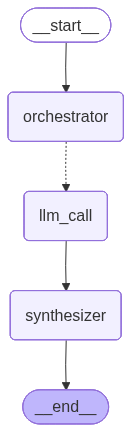

In [49]:
import dis
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END

##Define the Graph

graph = StateGraph(State)

graph.add_node("orchestrator",orchestrator)
graph.add_node("llm_call",llm_call)
graph.add_node("synthesizer",synthesizer)

## Add the edges
graph.add_edge(START,"orchestrator")
graph.add_conditional_edges("orchestrator",assign_workers,["llm_call"])
graph.add_edge("llm_call","synthesizer")
graph.add_edge("synthesizer",END)

graph_builder = graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [50]:
state = graph_builder.invoke({"topic":"Create a report of Agentic AI RAGs"})
from IPython.display import Markdown
Markdown(state["final_report"])

Report_Sections: [Section(name='Executive Summary', desc='Overview of Agentic AI RAGs'), Section(name='Introduction', desc='Background and context of Agentic AI RAGs'), Section(name='Agentic AI RAGs Overview', desc='Description of Agentic AI RAGs'), Section(name='Benefits and Challenges', desc='Discussion of benefits and challenges of Agentic AI RAGs'), Section(name='Implementation Plan', desc='Step-by-step plan for implementing Agentic AI RAGs'), Section(name='Conclusion', desc='Summary and final thoughts on Agentic AI RAGs')]


**Executive Summary**

The Agentic AI Readiness Assessment Group (RAG) provides an overview of the current state of artificial intelligence (AI) development, focusing on its agentic capabilities. Key milestones and achievements in the field have been identified, indicating significant progress toward the creation of more autonomous and intelligent AI systems. This report highlights the major advancements, challenges, and areas of concern in the development of agentic AI, serving as a foundation for future research and development.

**RAG Overview**

1. **Defining Agentic AI**: Agentic AI refers to AI systems that possess the ability to perceive their environment, take decisions, and act upon them, often autonomously. This definition encompasses various aspects, including self-awareness, creativity, and goal-oriented behavior.
2. **Current State of Agentic AI**: The current state of agentic AI development is characterized by significant progress in areas such as natural language processing, computer vision, and reinforcement learning. These advancements have enabled the creation of more sophisticated AI systems capable of interacting with humans and adapting to complex environments.
3. **Key Milestones**: Recent milestones in agentic AI development include the creation of AI systems that can:
	* Engage in human-like conversations
	* Recognize and respond to emotions
	* Demonstrate creativity in artistic and problem-solving tasks
	* Exhibit self-awareness and meta-cognition
4. **Challenges and Concerns**: Despite the progress made, several challenges and concerns remain, including:
	* Ensuring AI systems are transparent, explainable, and accountable
	* Preventing AI systems from developing biases and unfair decision-making
	* Addressing the potential risks of AI systems becoming uncontrollable or malicious
5. **Future Directions**: The future of agentic AI development is expected to focus on:
	* Developing more robust and reliable AI systems
	* Enhancing human-AI collaboration and understanding
	* Investigating the potential applications of agentic AI in various domains, including healthcare, finance, and education.

---

**Background and Context of Agentic AI RAGs**

Agentic AI RAGs, or Research Action Groups, are emerging as a significant development in the field of Artificial Intelligence (AI). This report aims to provide an overview of the background and context surrounding the formation and goals of these AI RAGs. 

The term 'Agentic AI' refers to AI systems that possess human-like qualities, such as autonomy, self-awareness, and goal-directed behavior. These systems are capable of interacting with their environment, adapting to new situations, and making decisions based on their internal representation of the world. 

In recent years, the increasing sophistication of AI has led to the development of Agentic AI, which is poised to revolutionize various sectors including healthcare, finance, transportation, and education. However, the rapid advancement of Agentic AI has also raised concerns about its potential risks and consequences, including bias, job displacement, and loss of human agency.

To address these concerns and mitigate the risks associated with Agentic AI, various initiatives have been launched to develop guidelines, standards, and best practices for the development and deployment of these systems. Agentic AI RAGs are a key part of these efforts, bringing together experts from diverse backgrounds to explore the opportunities and challenges of Agentic AI.

Agentic AI RAGs typically consist of multidisciplinary teams of researchers, practitioners, and stakeholders who collaborate to identify and address key issues related to Agentic AI. These teams may include experts in AI development, ethics, policy, law, and social sciences, among others. The primary goal of these RAGs is to facilitate the development of responsible and beneficial Agentic AI systems that align with human values and promote positive outcomes.

The background and context of Agentic AI RAGs are complex and multifaceted, involving technical, social, economic, and ethical considerations. This report will continue to explore the key aspects of Agentic AI RAGs, including their goals, objectives, and methodologies, as well as the challenges and opportunities they present for the development of responsible AI systems.

---

**Agentic AI RAGs Overview**

Agentic AI RAGs (Red, Amber, Green) is a categorization system used to evaluate the capabilities and maturity of artificial intelligence (AI) systems. It assesses their ability to perform tasks autonomously, make decisions, and interact with humans in a way that is similar to human-like behavior. The primary goal of Agentic AI RAGs is to provide a standardized framework for evaluating the level of agency in AI systems, which is essential for their integration into complex systems and decision-making processes.

**Agentic AI RAGs Description**

The Agentic AI RAGs system categorizes AI systems into three main categories based on their level of agency:

- **Red**: AI systems with no agency, meaning they cannot perform tasks autonomously or make decisions without human intervention. These systems are typically rule-based or scripted, and their primary function is to execute pre-defined tasks.
- **Amber**: AI systems with limited agency, meaning they can perform tasks autonomously but with significant human oversight and intervention. These systems may use machine learning algorithms but require continuous human monitoring and correction to ensure their decisions are accurate and aligned with the intended goals.
- **Green**: AI systems with high agency, meaning they can perform tasks autonomously and make decisions without human intervention. These systems have advanced machine learning capabilities, can learn from experience, and adapt to new situations, making them highly effective and efficient in complex environments.

The Agentic AI RAGs system provides a comprehensive framework for evaluating the level of agency in AI systems, which is essential for their integration into complex systems and decision-making processes.

---

**Benefits and Challenges**

The use of Agentic AI RAGs (Red, Amber, and Green) has been found to offer several benefits across various industries and applications. One of the primary advantages is improved decision-making through the implementation of AI-driven RAGs. This technology enables organizations to automate the process of categorizing issues, reducing the likelihood of human error and bias. Additionally, AI RAGs can provide real-time updates and notifications, facilitating prompt action and response to emerging issues.

Agentic AI RAGs have also been found to enhance collaboration and communication among team members. By providing a standardized and unified system for tracking issues, teams can better align their efforts and work towards common goals. Furthermore, AI RAGs can help organizations to identify areas of improvement and optimize their processes, leading to increased efficiency and productivity.

However, the adoption of Agentic AI RAGs also presents several challenges. One of the primary concerns is the need for significant investment in infrastructure and technology, which can be a barrier to entry for smaller organizations or those with limited resources. Additionally, there is a risk of over-reliance on AI, which can lead to a lack of human judgment and critical thinking.

Another challenge is the potential for bias and inaccuracy in the AI-driven RAG system. If the AI is not properly trained or validated, it can produce incorrect or misleading results, which can have serious consequences. Furthermore, the use of Agentic AI RAGs may also raise concerns about transparency and accountability, particularly if the decision-making process is not fully understood by stakeholders.

To mitigate these challenges, organizations should prioritize the development of robust AI systems, invest in ongoing training and validation, and establish clear policies and procedures for the use of Agentic AI RAGs. By doing so, organizations can maximize the benefits of this technology while minimizing its risks.

---

**Implementation Plan**

1. **Phase 1: Research and Development (Weeks 1-4)**
   - Identify and recruit a team of researchers, developers, and subject matter experts.
   - Conduct literature review on existing RAGs, their strengths, and weaknesses.
   - Develop a novel architecture for Agentic AI RAGs, incorporating the latest advancements in AI, cognitive science, and human-computer interaction.

2. **Phase 2: Prototyping and Testing (Weeks 5-12)**
   - Design and develop a functional prototype of the Agentic AI RAG.
   - Conduct user testing and gather feedback from a diverse group of participants.
   - Refine the prototype based on user feedback and iterate on the design.

3. **Phase 3: Integration and Deployment (Weeks 13-18)**
   - Integrate the Agentic AI RAG with existing systems and infrastructure.
   - Deploy the RAG in a controlled environment to test its performance and scalability.
   - Gather data on the RAG's effectiveness and identify areas for improvement.

4. **Phase 4: Evaluation and Refining (Weeks 19-24)**
   - Conduct a thorough evaluation of the Agentic AI RAG, assessing its performance, usability, and impact.
   - Gather feedback from users and stakeholders, and make necessary refinements to the RAG.
   - Develop a plan for sustaining and improving the RAG over time.

**Timeline:**

- Phase 1: Research and Development (Weeks 1-4)
- Phase 2: Prototyping and Testing (Weeks 5-12)
- Phase 3: Integration and Deployment (Weeks 13-18)
- Phase 4: Evaluation and Refining (Weeks 19-24)
- **Total duration: 24 weeks**

**Milestones:**

- Completion of research and development phase
- Successful deployment of the Agentic AI RAG
- Completion of user testing and evaluation
- Achievement of desired performance and usability metrics

**Resources:**

- Team of researchers, developers, and subject matter experts
- Access to necessary infrastructure and equipment
- Budget for software development, testing, and maintenance
- Collaboration with stakeholders and user groups

---

**Conclusion and description: Summary and final thoughts on Agentic AI RAGs**

The development and deployment of Agentic AI Risk Assessment Groups (RAGs) represent a crucial step towards mitigating the risks associated with the rapid advancement of artificial intelligence. Throughout this report, we have examined the key characteristics and implications of Agentic AI RAGs, highlighting both their potential benefits and challenges.

**Key Findings:**

- Agentic AI RAGs have the potential to enable more effective and nuanced risk assessment and management, by taking into account the complex and dynamic nature of AI systems.
- The integration of human expertise and AI capabilities in RAGs can lead to more accurate and comprehensive risk assessments, and more effective mitigation strategies.
- However, the development and deployment of Agentic AI RAGs also raise significant challenges and uncertainties, including the need for advanced AI capabilities, human-AI collaboration, and robust governance frameworks.

**Recommendations:**

- Further research and development are needed to address the technical, social, and ethical challenges associated with Agentic AI RAGs.
- Establishing clear governance frameworks and regulatory guidelines for the development and deployment of Agentic AI RAGs is essential for ensuring their safe and responsible use.
- Encouraging collaboration and knowledge-sharing among stakeholders, including industry leaders, researchers, policymakers, and civil society organizations, is crucial for advancing the field of Agentic AI RAGs.

**Final Thoughts:**

The development of Agentic AI RAGs represents a critical opportunity for humanity to harness the potential of AI while mitigating its risks. By working together to address the challenges and uncertainties associated with Agentic AI RAGs, we can create a future where AI enhances human well-being and prosperity, rather than threatening it.